In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Recall, Precision

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
import os
import shutil

folder_path = "/content/tuberculosis_data"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
else:
    print(f"Folder not found: {folder_path}")


Folder not found: /content/tuberculosis_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/tuberculosis/archive.zip'

extract_path = '/content/tuberculosis_data'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed! Files are in:", extract_path)


Extraction completed! Files are in: /content/tuberculosis_data


In [ ]:
tb_dir='/content/tuberculosis_data/TBX11K/imgs/tb'
len(os.listdir(tb_dir))

800

In [ ]:
import os
dataset_url = '/content/tuberculosis_data/TBX11K'
os.chdir('/content/tuberculosis_data/TBX11K')

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
dataset_path = '/content/tuberculosis_data/TBX11K/imgs'
folder_labels = {"tb": 0, "healthy": 1, "health": 1}

In [ ]:
images, labels = [], []
for folder in os.listdir(dataset_path):
    folder_name = folder.lower()
    if folder_name not in folder_labels:
        continue
    print(f"Processing folder: {folder}")
    folder_path = os.path.join(dataset_path, folder)
    count = 0
    for i, img_name in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (256, 256))
        images.append(img)
        labels.append(folder_labels[folder_name])
        count += 1
        if count == 1000:
            break

print("Finished loading images!")

Processing folder: health
Processing folder: tb
Finished loading images!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(labels)
images = np.array(images)

class_names = {0: "TB", 1: "Healthy"}


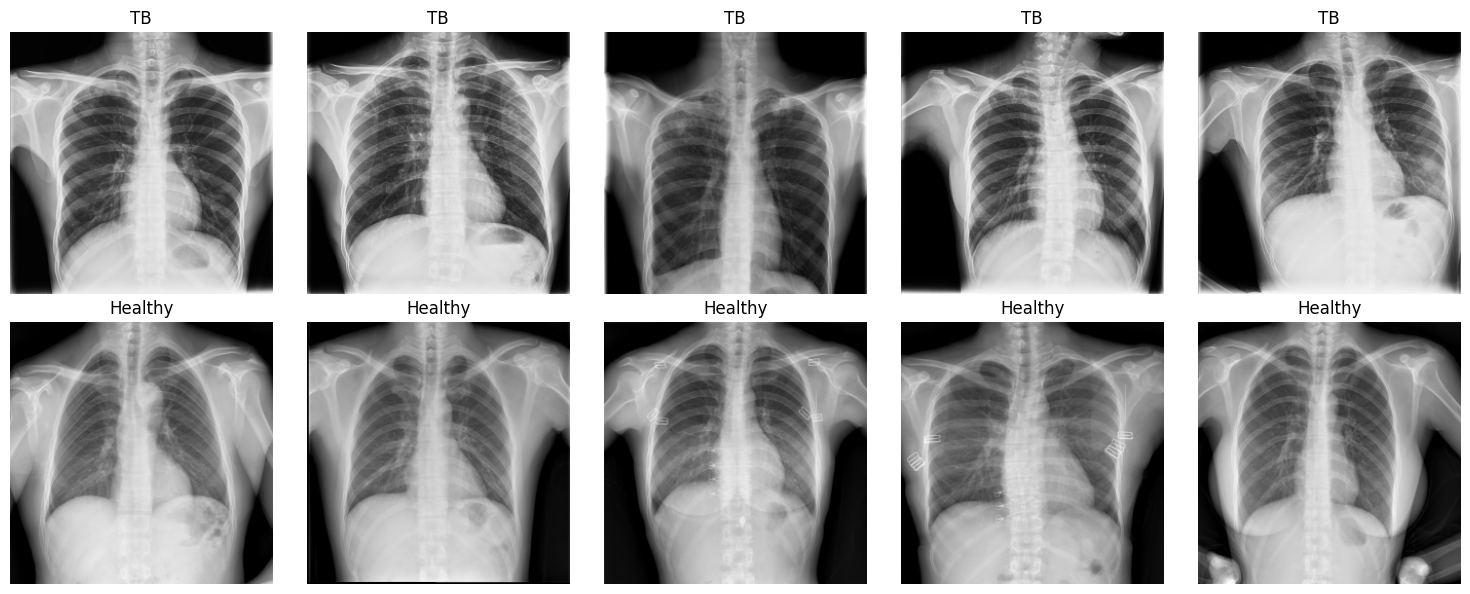

In [ ]:
n_samples = 5

plt.figure(figsize=(15, 6))

tb_indices = np.where(labels == 0)[0][:n_samples]
for i, idx in enumerate(tb_indices):
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"{class_names[0]}")
    plt.axis("off")

healthy_indices = np.where(labels == 1)[0][:n_samples]
for i, idx in enumerate(healthy_indices):
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"{class_names[1]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
labels = np.array(labels)
images = np.array(images)

# Step 4: Train-test split
indices_train, indices_test = train_test_split(
    list(range(images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True
)
x_train = images[indices_train]
y_train = labels[indices_train]
x_test = images[indices_test]
y_test = labels[indices_test]

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
num_classes = 2
input_shape = (256, 256, 3)
learning_rate = 0.001
batch_size = 16
num_epochs = 30
image_size = 256
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomZoom(0.2, 0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=num_patches, delta=1)
        return self.projection(patch) + self.position_embedding(positions)

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes, activation="softmax")(features)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
model = create_vit_classifier()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          7 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 192) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 1024, 64)  │     77,888 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1024, 64)  │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1024, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024, 64)  │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1024, 64)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1024, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1024, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024, 128) │          0 │ dense_3[0][0]   

 Total params: 137,063,625 (522.86 MB)

 Trainable params: 137,063,618 (522.86 MB)

 Non-trainable params: 7 (32.00 B)

In [ ]:
checkpoint_path = "best_vit_model.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, monitor='val_accuracy',
    verbose=1, save_best_only=True, mode='max'
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

In [ ]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3,
    min_lr=1e-6, verbose=1
)

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, early_stop, lr_reduce]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.5771 - loss: 17.6406
Epoch 1: val_accuracy improved from -inf to 0.80278, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 744ms/step - accuracy: 0.5777 - loss: 17.5898 - val_accuracy: 0.8028 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6785 - loss: 2.5912
Epoch 2: val_accuracy improved from 0.80278 to 0.81667, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6787 - loss: 2.5846 - val_accuracy: 0.8167 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6928 - loss: 1.1652
Epoch 3: val_accuracy improved from 0.81667 to 0.82778, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6931 - loss: 1.1627 - val_accuracy: 0.8278 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7571 - loss: 0.6131
Epoch 4: val_accuracy did not improve from 0.82778
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 583ms/step - accuracy: 0.7570 - loss: 0.6130 - val_accuracy: 0.8167 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7987 - loss: 0.5097
Epoch 5: val_accuracy improved from 0.82778 to 0.90833, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 111s 911ms/step - accuracy: 0.7986 - loss: 0.5098 - val_accuracy: 0.9083 - val_loss: 0.2909 - learning_rate: 0.0010
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8164 - loss: 0.4556
Epoch 6: val_accuracy did not improve from 0.90833
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 577ms/step - accuracy: 0.8166 - loss: 0.4552 - val_accuracy: 0.9056 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8479 - loss: 0.3975
Epoch 7: val_accuracy did not improve from 0.90833
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 585ms/step - accuracy: 0.8479 - loss: 0.3975 - val_accuracy: 0.8639 - val_loss: 0.3206 - learning_rate: 0.0010
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8530 - loss: 0.4054
Epoch 8: val_accuracy improved from 0.90833 to 0.92778, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 115s 961ms/step - accuracy: 0.8529 - loss: 0.4056 - val_accuracy: 0.9278 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8650 - loss: 0.3704
Epoch 9: val_accuracy did not improve from 0.92778

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
90/90 ━━━━━━━━━━━━━━━━━━━━ 109s 588ms/step - accuracy: 0.8649 - loss: 0.3705 - val_accuracy: 0.9194 - val_loss: 0.2422 - learning_rate: 0.0010
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8854 - loss: 0.3036
Epoch 10: val_accuracy improved from 0.92778 to 0.94444, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 98s 768ms/step - accuracy: 0.8854 - loss: 0.3037 - val_accuracy: 0.9444 - val_loss: 0.2407 - learning_rate: 5.0000e-04
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9017 - loss: 0.2632
Epoch 11: val_accuracy did not improve from 0.94444
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 576ms/step - accuracy: 0.9017 - loss: 0.2633 - val_accuracy: 0.9278 - val_loss: 0.2049 - learning_rate: 5.0000e-04
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9004 - loss: 0.2697
Epoch 12: val_accuracy did not improve from 0.94444
90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 592ms/step - accuracy: 0.9004 - loss: 0.2698 - val_accuracy: 0.9222 - val_loss: 0.1838 - learning_rate: 5.0000e-04
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9155 - loss: 0.2411
Epoch 13: val_accuracy did not improve from 0.94444
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - accuracy: 0.9155 - loss: 0.2410 - val_accuracy: 0.9333 - val_loss: 0.2050 - learning_rate: 5.0000e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 751ms/step - accuracy: 0.9180 - loss: 0.2306 - val_accuracy: 0.9528 - val_loss: 0.1656 - learning_rate: 2.5000e-04
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9116 - loss: 0.2368
Epoch 17: val_accuracy did not improve from 0.95278
90/90 ━━━━━━━━━━━━━━━━━━━━ 68s 589ms/step - accuracy: 0.9116 - loss: 0.2367 - val_accuracy: 0.9389 - val_loss: 0.1794 - learning_rate: 2.5000e-04
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9194 - loss: 0.1826
Epoch 18: val_accuracy did not improve from 0.95278
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 568ms/step - accuracy: 0.9193 - loss: 0.1828 - val_accuracy: 0.9528 - val_loss: 0.1752 - learning_rate: 2.5000e-04
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9175 - loss: 0.1940
Epoch 19: val_accuracy did not improve from 0.95278
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 596ms/step - accuracy: 0.9176 - loss: 0.1941 - val_accuracy: 0.9500 - val_loss: 0.1566 - learning_rate: 2.5000e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 108s 890ms/step - accuracy: 0.9252 - loss: 0.1922 - val_accuracy: 0.9611 - val_loss: 0.1479 - learning_rate: 2.5000e-04
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9361 - loss: 0.1982
Epoch 21: val_accuracy improved from 0.96111 to 0.96389, saving model to best_vit_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 873ms/step - accuracy: 0.9361 - loss: 0.1981 - val_accuracy: 0.9639 - val_loss: 0.1368 - learning_rate: 2.5000e-04
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9249 - loss: 0.1907
Epoch 22: val_accuracy did not improve from 0.96389
90/90 ━━━━━━━━━━━━━━━━━━━━ 55s 569ms/step - accuracy: 0.9249 - loss: 0.1907 - val_accuracy: 0.9333 - val_loss: 0.1679 - learning_rate: 2.5000e-04
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9394 - loss: 0.1917
Epoch 23: val_accuracy did not improve from 0.96389
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - accuracy: 0.9394 - loss: 0.1916 - val_accuracy: 0.9361 - val_loss: 0.1753 - learning_rate: 2.5000e-04
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9342 - loss: 0.2039
Epoch 24: val_accuracy did not improve from 0.96389

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 589ms/step - accuracy: 0.9343 - loss

90/90 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9447 - loss: 0.1598 - val_accuracy: 0.9667 - val_loss: 0.1291 - learning_rate: 1.2500e-04
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9386 - loss: 0.1622
Epoch 27: val_accuracy did not improve from 0.96667
90/90 ━━━━━━━━━━━━━━━━━━━━ 91s 589ms/step - accuracy: 0.9385 - loss: 0.1625 - val_accuracy: 0.9667 - val_loss: 0.1583 - learning_rate: 1.2500e-04
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9340 - loss: 0.1687
Epoch 28: val_accuracy did not improve from 0.96667
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - accuracy: 0.9340 - loss: 0.1687 - val_accuracy: 0.9583 - val_loss: 0.1402 - learning_rate: 1.2500e-04
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9294 - loss: 0.1807
Epoch 29: val_accuracy did not improve from 0.96667

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 569ms/step - accuracy: 0.9295 - loss: 0

In [ ]:
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)} %")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.9742 - loss: 0.1205
Test loss: 0.13
Test accuracy: 96.67 %


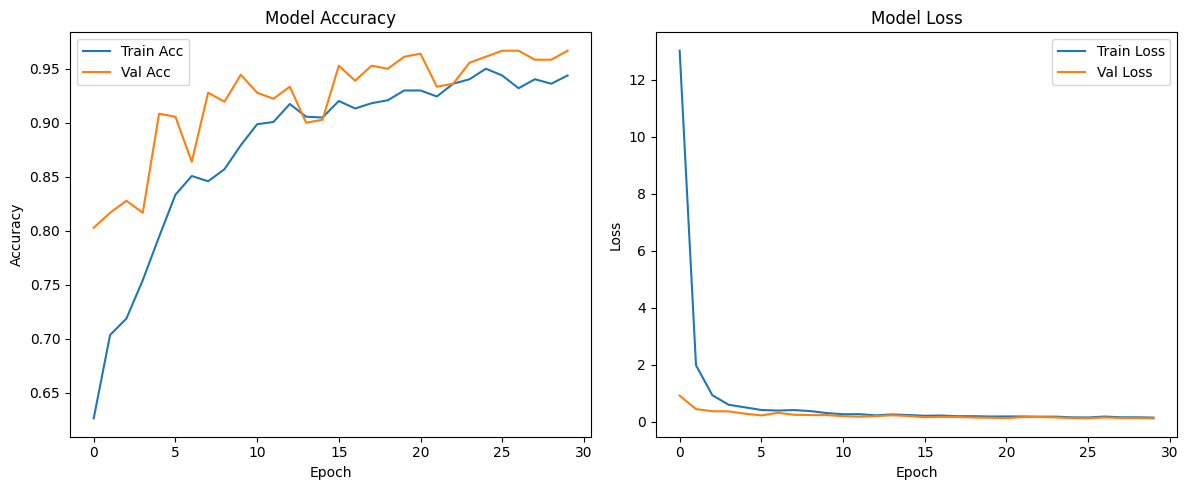

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step


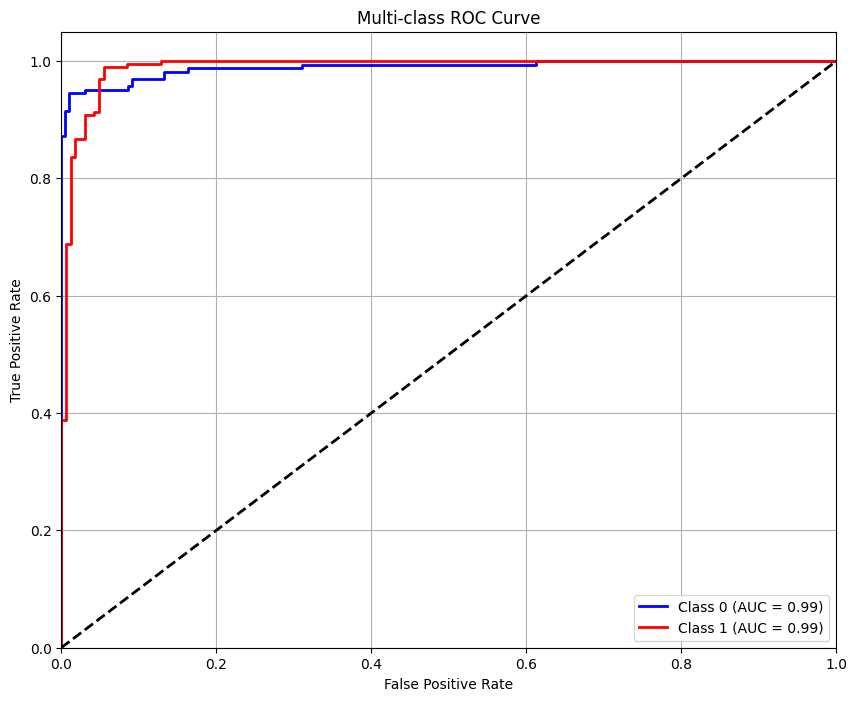

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

n_classes = y_test.shape[1]

y_score = model.predict(x_test)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f0340a2ab3f104c2726befe648d8fe2c0da61aec2ebcc53f28bb9a7f36921ca9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import random
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
idx = random.randint(0, len(x_test) - 1)
img = x_test[idx]
input_img = np.expand_dims(img, axis=0)

In [ ]:
def get_attention_map(vit_model, input_image):
    attention_layer = None
    for layer in reversed(vit_model.layers):
        if isinstance(layer, tf.keras.layers.MultiHeadAttention):
            attention_layer = layer
            break
    if attention_layer is None:
        raise ValueError("No MultiHeadAttention layer found in the model.")

    attention_model = Model(inputs=vit_model.input, outputs=attention_layer.output)
    attention_output = attention_model.predict(input_image)


    if len(attention_output.shape) == 4:
        attention_map = np.mean(attention_output[0], axis=-1)
    else:
        attention_map = attention_output[0]

    attention_map = np.mean(attention_map, axis=0)
    side = int(np.sqrt(attention_map.shape[0]))
    attention_map = attention_map.reshape((side, side))
    attention_map = cv2.resize(attention_map, (256, 256))
    attention_map = np.uint8(255 * attention_map / np.max(attention_map))
    return attention_map

In [ ]:
def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return overlay


In [ ]:
attention_map = get_attention_map(model, input_img)
attention_result = overlay_heatmap(attention_map, img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


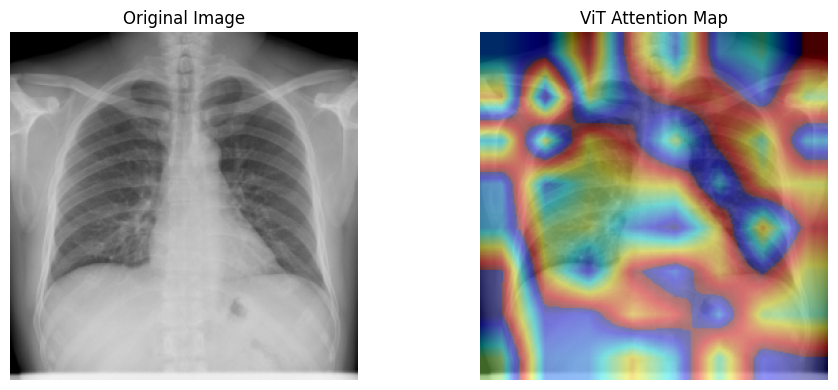

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(attention_result.astype("uint8"))
plt.title("ViT Attention Map")
plt.axis("off")
plt.tight_layout()
plt.show()

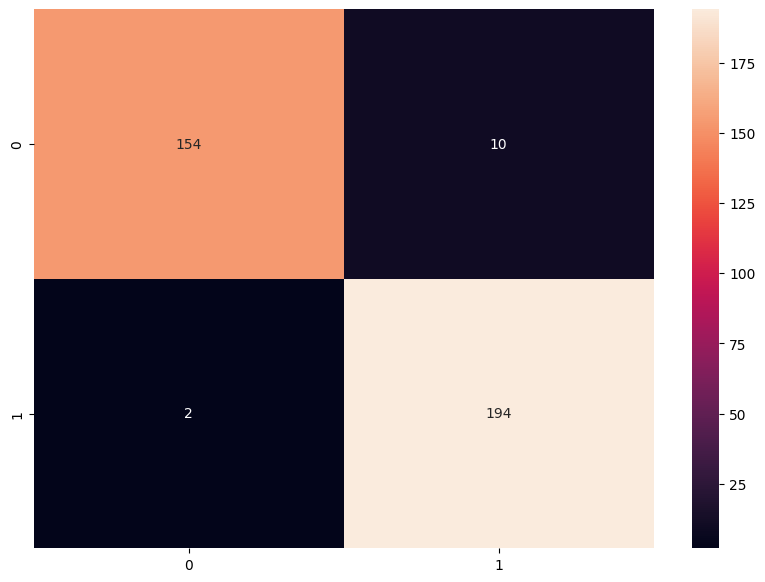

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.savefig("/content/tuberculosis_data/TBX11K/CM.png")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

classes = ['TB', 'HEALTHY']

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred

print("✅ Unique labels in y_test:", np.unique(y_test_labels))
print("✅ Unique labels in y_pred:", np.unique(y_pred_labels))

report = classification_report(
    y_test_labels,
    y_pred_labels,
    labels=[0, 1],
    target_names=classes,
    zero_division=0
)
print(report)


✅ Unique labels in y_test: [0 1]
✅ Unique labels in y_pred: [0 1]
              precision    recall  f1-score   support

          TB       0.99      0.94      0.96       164
     HEALTHY       0.95      0.99      0.97       196

    accuracy                           0.97       360
   macro avg       0.97      0.96      0.97       360
weighted avg       0.97      0.97      0.97       360



In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
dataset_path = "/content/tuberculosis_data/TBX11K/imgs"

folder_labels = {
    "tb": 0,
    "health": 1,
}

In [4]:
images, labels = [], []

In [5]:
for folder in os.listdir(dataset_path):
    folder_name = folder.lower()


    if folder_name not in folder_labels:
        continue

    print(f"Processing folder: {folder}")
    folder_path = os.path.join(dataset_path, folder)
    count = 0

    for i, img_name in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (256, 256))
        images.append(img)
        labels.append(folder_labels[folder_name])

        count += 1
        if i % 100 == 0:
            print(f"Processed {i} images in {folder}")

        if count == 1000:
            break

print("Finished loading images!")

Processing folder: health
Processed 0 images in health
Processed 100 images in health
Processed 200 images in health
Processed 300 images in health
Processed 400 images in health
Processed 500 images in health
Processed 600 images in health
Processed 700 images in health
Processed 800 images in health
Processed 900 images in health
Processing folder: tb
Processed 0 images in tb
Processed 100 images in tb
Processed 200 images in tb
Processed 300 images in tb
Processed 400 images in tb
Processed 500 images in tb
Processed 600 images in tb
Processed 700 images in tb
Finished loading images!


In [6]:
image = np.array(images)
label = np.array(labels)


print("Image shape:", image.shape)
print("Unique labels:", pd.Series(label).value_counts())

indices_train, indices_test = train_test_split(
    np.arange(image.shape[0]),
    train_size=0.8,
    test_size=0.2,
    shuffle=True,
    stratify=label
)

x_train = image[indices_train]
y_train = label[indices_train]
x_test = image[indices_test]
y_test = label[indices_test]

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


Image shape: (1800, 256, 256, 3)
Unique labels: 1    1000
0     800
Name: count, dtype: int64
Train shape: (1440, 256, 256, 3) (1440,)
Test shape: (360, 256, 256, 3) (360,)


In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print("Encoded labels shape:", y_train.shape, y_test.shape)

Encoded labels shape: (1440, 2) (360, 2)


In [8]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 200
image_size = 256
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from lime import lime_image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
if len(y_train.shape) == 2 and y_train.shape[1] == 2:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

In [12]:
def create_densenet_model(input_shape=(256, 256, 3), num_classes=1):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)


    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [13]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

In [17]:
densenet_model = create_densenet_model()
densenet_model.compile(optimizer=optimizers.Adam(1e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [18]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [19]:
history = densenet_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 656ms/step - accuracy: 0.5815 - loss: 0.7137 - val_accuracy: 0.6389 - val_loss: 0.6281 - learning_rate: 1.0000e-05
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.7184 - loss: 0.5481 - val_accuracy: 0.8667 - val_loss: 0.5040 - learning_rate: 1.0000e-05
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8407 - loss: 0.3818 - val_accuracy: 0.9167 - val_loss: 0.3991 - learning_rate: 1.0000e-05
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8494 - loss: 0.3693 - val_accuracy: 0.9167 - val_loss: 0.3209 - learning_rate: 1.0000e-05
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8776 - loss: 0.3115 - val_accuracy: 0.9250 - val_loss: 0.2658 - learning_rate: 1.0000e-05
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8859 - loss: 0.2859 - val_accuracy: 0.9333 - val_loss: 0.2285 - learning_rate: 1.0000e-05
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accurac

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9916 - loss: 0.0511
Test Loss: 0.058818474411964417
Test Accuracy: 0.9861111044883728


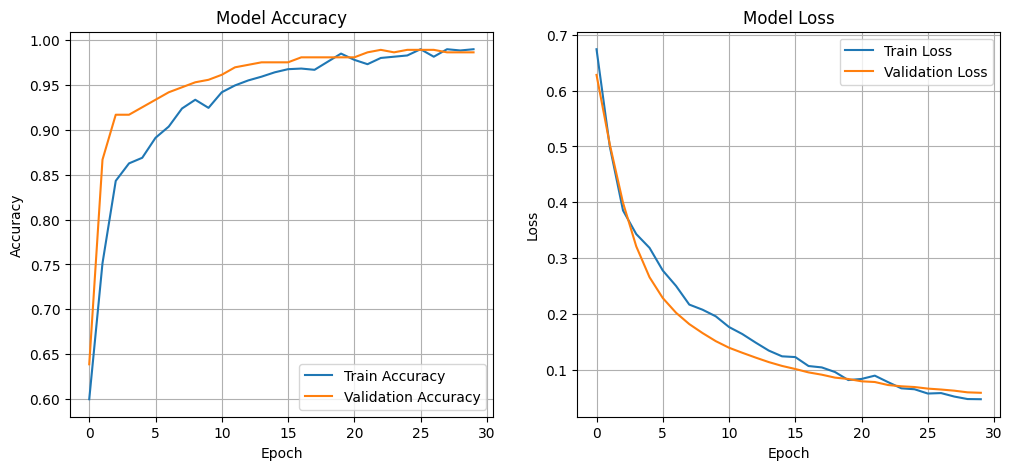

In [20]:
test_loss, test_accuracy = densenet_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
plot_training_history(history)

<ipython-input-21-5ca35e073c07>:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-5ca35e073c07>:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


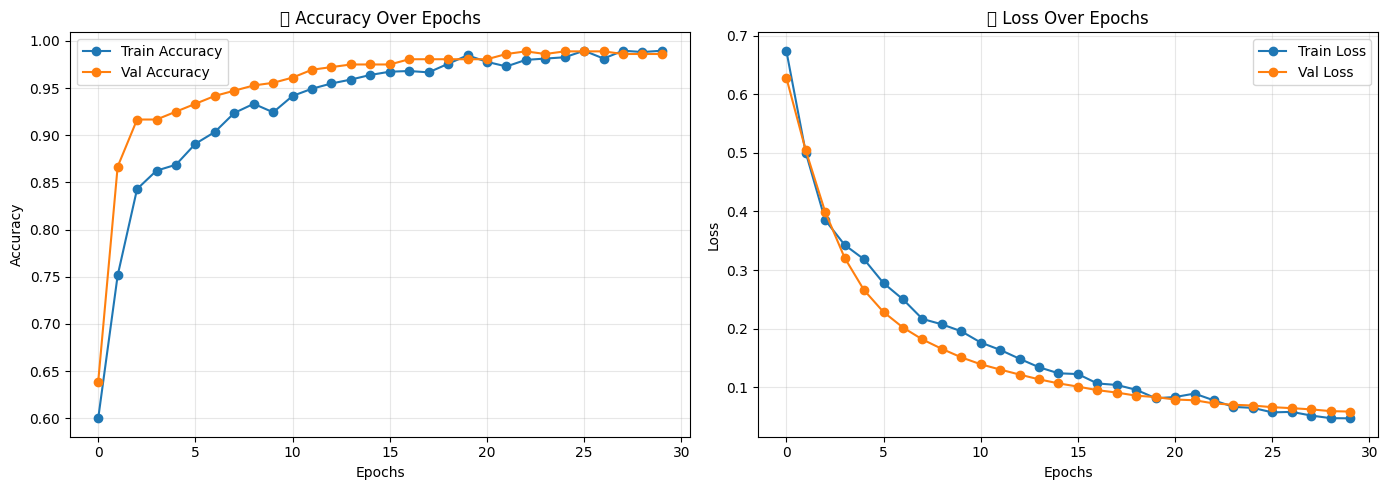

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt

In [23]:
def GradCAM(model, image, interpolant=0.5, plot_results=True):
    # Prepare input image batch (1, H, W, C)
    img = np.expand_dims(image.astype(np.float32), axis=0)

    # Predict output probability
    preds = model.predict(img)
    pred_prob = preds[0][0]
    pred_class = 1 if pred_prob > 0.5 else 0

    # Find the last Conv2D layer in the model
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        raise ValueError("No Conv2D layer found in the model.")

    # Create a model that outputs both the last conv output and predictions
    grad_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, 0]  # binary output

    # Compute gradients of loss w.r.t conv outputs
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU (keep only positive influences)
    heatmap = tf.nn.relu(heatmap)

    # Resize heatmap to match image size
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (image.shape[0], image.shape[1]))
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    # Convert to uint8 0-255 heatmap
    heatmap = tf.cast(255 * heatmap, tf.uint8).numpy()

    # Apply color map (JET)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    # Make sure image is uint8 and 3 channels for color overlay
    if image.dtype != np.uint8:
        image_uint8 = np.uint8(image * 255) if image.max() <= 1 else image.astype(np.uint8)
    else:
        image_uint8 = image

    if image_uint8.shape[-1] == 1 or len(image_uint8.shape) == 2:
        # If grayscale, convert to BGR for OpenCV
        image_color = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2BGR)
    else:
        image_color = image_uint8

    overlay = cv2.addWeighted(image_color, interpolant, heatmap_color, 1 - interpolant, 0)

    if plot_results:
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title("Grad-CAM")
        plt.axis("off")
        plt.show()
    else:
        return overlay

In [24]:
# ---------- 7. LIME Explainability ----------
explainer = lime_image.LimeImageExplainer()

In [25]:
# Use DenseNet preprocessing inside predict_fn for LIME
from tensorflow.keras.applications.densenet import preprocess_input

In [26]:
def predict_fn(images):
    # images come as uint8, shape (N, H, W, C)
    images = images.astype(np.float32)
    images = preprocess_input(images)  # important!
    return densenet_model.predict(images)

In [27]:
sample_index=0

In [28]:
explanation = explainer.explain_instance(
    x_test[sample_index],
    predict_fn,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

In [29]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

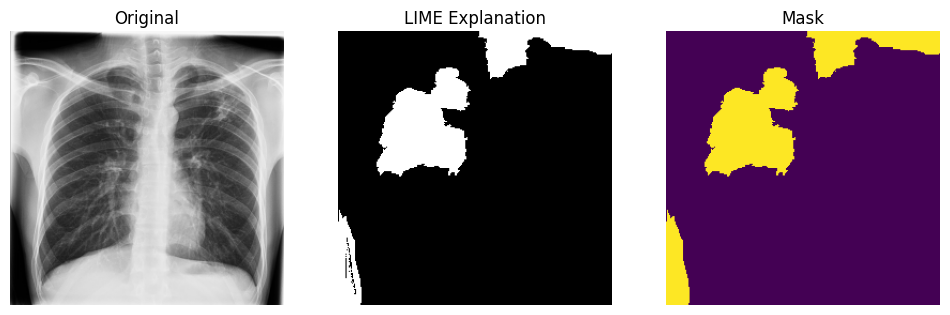

In [30]:
# Plot LIME explanation
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(x_test[sample_index].astype(np.uint8))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(temp)
plt.title("LIME Explanation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")
plt.show()

In [31]:
# ---------- 8. Classification Report & Confusion Matrix ----------
y_pred_probs = densenet_model.predict(x_test)
y_pred_binary = (y_pred_probs > 0.5).astype(int).reshape(-1)
y_test_binary = y_test.reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [32]:
# Classification report
report = classification_report(y_test_binary, y_pred_binary)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       160
           1       0.99      0.98      0.99       200

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



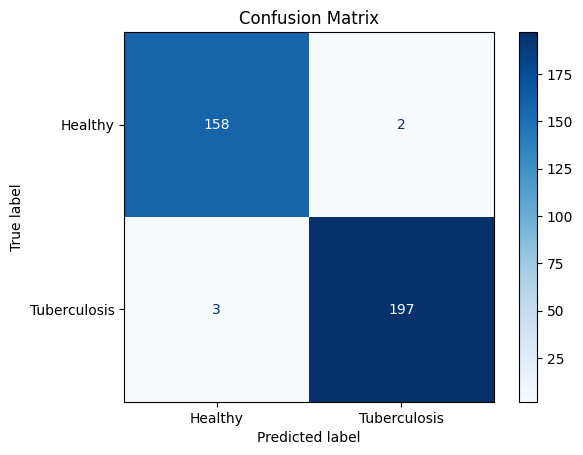

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tuberculosis"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from lime import lime_image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.densenet import preprocess_input
from skimage.segmentation import mark_boundaries

In [35]:
# ----------- LIME ----------- #
explainer_lime = lime_image.LimeImageExplainer()

In [36]:
def predict_fn(images):
    images = preprocess_input(images.astype(np.float32))
    return densenet_model.predict(images)

In [37]:
explanation = explainer_lime.explain_instance(
    x_test[sample_index],
    predict_fn,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━

In [38]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

In [39]:
# ----------- GradCAM ----------- #
def GradCAM(model, image, interpolant=0.5, plot_results=False):
    img = np.expand_dims(image.astype(np.float32), axis=0)
    preds = model.predict(img)
    pred_prob = preds[0][0]
    pred_class = 1 if pred_prob > 0.5 else 0

    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        raise ValueError("No Conv2D layer found in the model.")

    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (image.shape[0], image.shape[1]))
    heatmap = tf.squeeze(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = tf.cast(255 * heatmap, tf.uint8).numpy()
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    image_uint8 = np.uint8(image * 255) if image.max() <= 1 else image.astype(np.uint8)
    if image_uint8.shape[-1] == 1 or len(image_uint8.shape) == 2:
        image_color = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2BGR)
    else:
        image_color = image_uint8

    overlay = cv2.addWeighted(image_color, interpolant, heatmap_color, 1 - interpolant, 0)

    if plot_results:
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title("Grad-CAM")
        plt.axis("off")
        plt.show()
    return overlay

In [40]:
# GradCAM overlay
gradcam_overlay = GradCAM(densenet_model, x_test[sample_index], plot_results=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_431']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


In [41]:
# ----------- Plot Original, GradCAM, LIME ----------- #
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

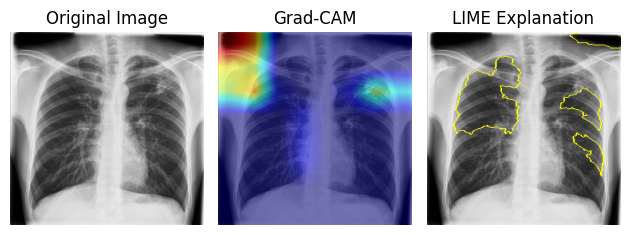

In [42]:
# Original
plt.subplot(1, 3, 1)
plt.imshow(x_test[sample_index].astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

# GradCAM
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")

plt.tight_layout()
plt.show()